In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

In [2]:
path = Path('./data')
seed = 21

In [3]:
df = pd.read_csv(path/'possum.csv')
df.drop(columns='case', inplace=True)

df.head(3)

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0


In [4]:
df.dtypes

site          int64
Pop          object
sex          object
age         float64
hdlngth     float64
skullw      float64
totlngth    float64
taill       float64
footlgth    float64
earconch    float64
eye         float64
chest       float64
belly       float64
dtype: object

In [5]:
num_cols = [
    'hdlngth', 'skullw', 'totlngth', 'taill',
    'footlgth', 'earconch', 'eye', 'chest', 'belly', 'possum_is_old',
]

str_cols = [
    'Pop', 'sex'
]

In [6]:
df.isna().sum()

site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

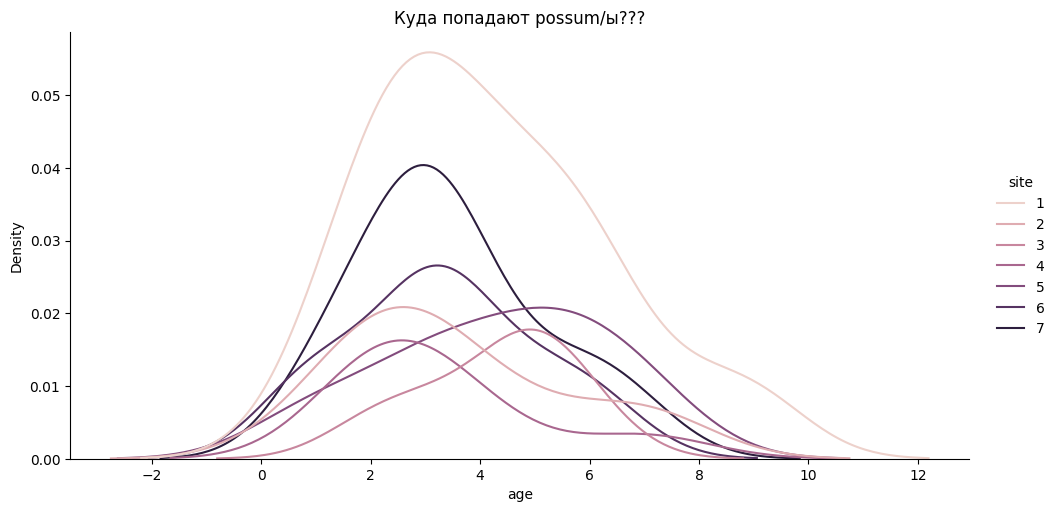

In [7]:
# многие possum/ы попадают в капкан, если им от 3 до 4 лет

g = sns.displot(
    x=df.age,
    aspect=2,
    kind='kde',
    hue=df.site
)

plt.title('Куда попадают possum/ы???')
plt.show()

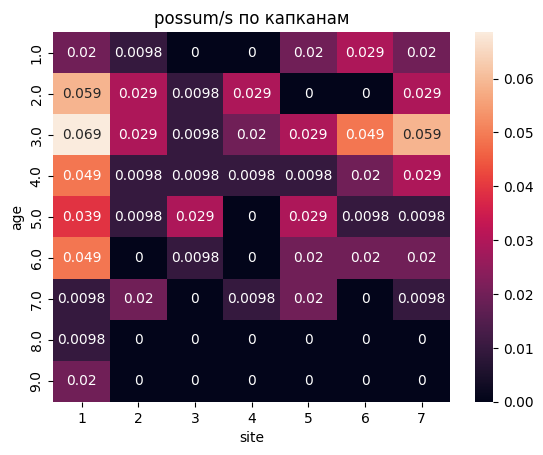

In [8]:
g = sns.heatmap(
    pd.crosstab(
        df.age,
        df.site,
        normalize=True
    ), 
    annot = True
)
g.set_title('possum/s по капканам');

In [9]:
df['possum_is_old'] = 0
df.loc[df.age > 7, 'possum_is_old'] = 1
df.query('age > 7')

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,possum_is_old
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1
8,1,Vic,f,9.0,93.4,56.3,91.5,37.0,72.4,52.9,15.5,28.0,33.0,1
10,1,Vic,f,9.0,93.3,57.2,89.5,39.0,77.2,51.3,14.9,31.0,34.0,1


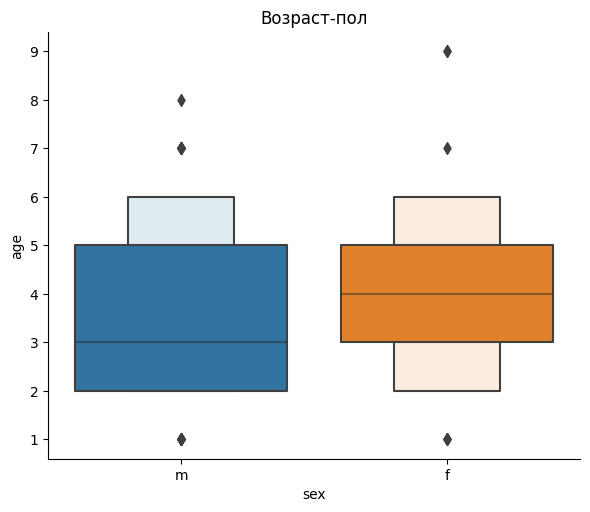

In [10]:
g = sns.catplot(
    data=df,
    y='age',
    x='sex',
    kind='boxen',
    aspect=1.2,
)

plt.title('Возраст-пол')
plt.show()

In [11]:
df[num_cols].corr().style.background_gradient(cmap='coolwarm')

,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,possum_is_old
hdlngth,1.000000,0.710827,0.691094,0.287429,0.391605,0.121463,0.347175,0.631498,0.562663,0.048325
skullw,0.710827,1.000000,0.526413,0.255921,0.275059,-0.000537,0.321991,0.629737,0.451838,0.060241
totlngth,0.691094,0.526413,1.000000,0.565646,0.444832,0.154484,0.247786,0.577890,0.519465,0.116974
taill,0.287429,0.255921,0.565646,1.000000,-0.126277,-0.385136,0.198134,0.174997,0.294493,0.028610
footlgth,0.391605,0.275059,0.444832,-0.126277,1.000000,0.783050,0.005213,0.450590,0.302584,0.247132
earconch,0.121463,-0.000537,0.154484,-0.385136,0.783050,1.000000,-0.165092,0.199230,0.066527,0.200988
eye,0.347175,0.321991,0.247786,0.198134,0.005213,-0.165092,1.000000,0.149338,0.235716,0.025365
chest,0.631498,0.629737,0.577890,0.174997,0.450590,0.199230,0.149338,1.000000,0.606170,0.169320
belly,0.562663,0.451838,0.519465,0.294493,0.302584,0.066527,0.235716,0.606170,1.000000,0.109528
possum_is_old,0.048325,0.060241,0.116974,0.028610,0.247132,0.200988,0.025365,0.169320,0.109528,1.000000


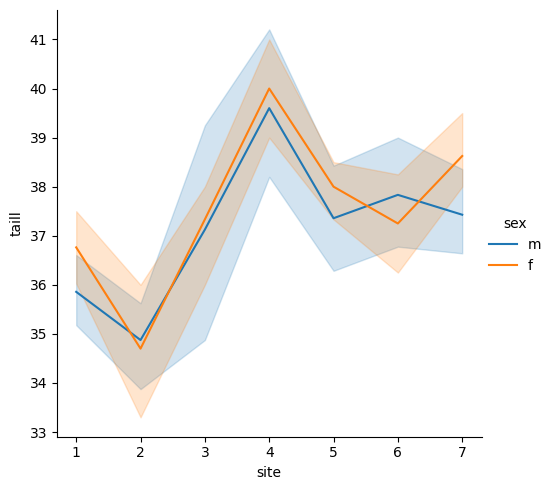

In [12]:
sns.relplot(
    data=df,
    x='site',
    y='taill',
    kind='line',
    hue='sex'
)

In [13]:
df['tail_is_bad'] = 0
df.loc[df['taill'] > 38, 'tail_is_bad'] = 1
num_cols.append('tail_is_bad')
df


,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,possum_is_old,tail_is_bad
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,0,0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,0,1
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,0,0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,m,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,0,0
100,7,other,m,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0,1
101,7,other,f,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,0,0
102,7,other,m,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0,0,0


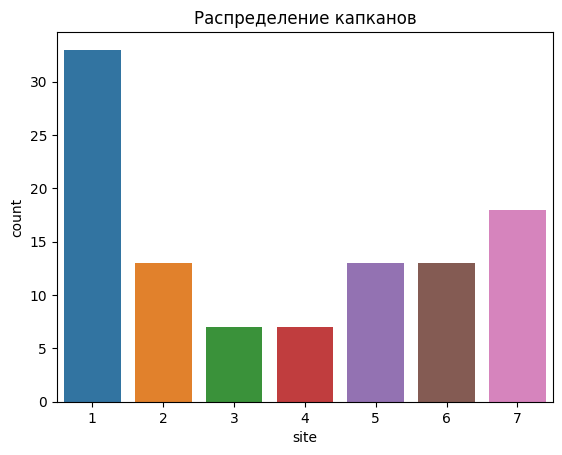

In [14]:
g = sns.countplot(
    data=df,
    x='site'
)
g.set_title('Распределение капканов');

In [23]:
num_prepro = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
])

cat_prepro = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

trf = ColumnTransformer([
    ('num_trf', num_prepro, num_cols),
    ('cat_trf', cat_prepro, str_cols),
]) 

clf_pipeline = Pipeline([
    ('trf', trf),
    ('clf', RandomForestClassifier())
])

In [25]:
# Данных мало, делить нет смысла
X = df.copy(True)
y = df.pop('site')

In [36]:
params = {
 'clf__bootstrap': [True, False],
 'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'clf__min_samples_leaf': [1, 2, 4],
 'clf__min_samples_split': [2, 5, 10],
 'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = GridSearchCV(
    estimator=clf_pipeline,
    scoring='f1_weighted',
    param_grid=params,
    n_jobs=-1,
    refit=True,
    verbose=2
)

In [ ]:
clf.fit(X, y)

In [53]:
importances = clf.best_estimator_.named_steps['clf'].feature_importances_


In [55]:
len(X.columns)


15

In [63]:
pd.DataFrame(importances.reshape(1, -1), columns=X.columns)

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,possum_is_old,tail_is_bad
0,0.097138,0.069464,0.106838,0.047749,0.116788,0.143604,0.081419,0.071652,0.05267,0.000218,0.007352,0.086692,0.09664,0.011337,0.010439
